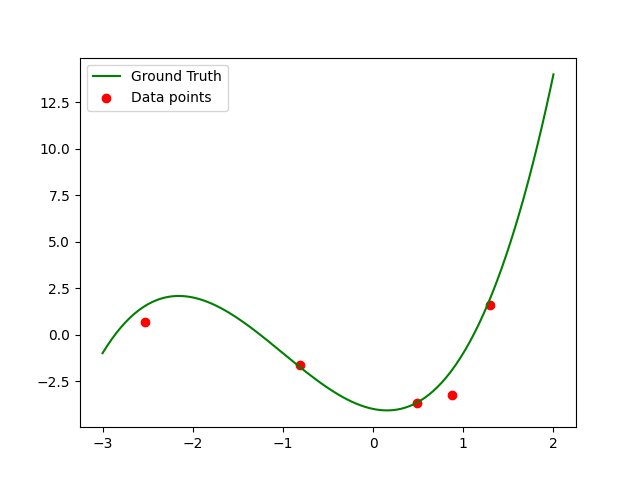

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets

x_min, x_max = -3, 2
num_data = 5
data_noise = 1.0
num_plot = 200

def fun(x):
    return x**3 + 3 * x**2 - x - 4

gen = np.random.default_rng(seed=42)
x_data = gen.uniform(size=(num_data,), low=x_min, high=x_max)
y_data = fun(x_data) + data_noise * gen.standard_normal(x_data.shape) 

x_plot = np.linspace(x_min, x_max, num=num_plot)
y_plot = fun(x_plot)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, y_plot, color="green", label="Ground Truth")
ax.scatter(x_data, y_data, color="red", label="Data points")
ax.legend(loc="upper left")
None

In [2]:
def create_rbf_feature_fun(n: int, dtype=np.float64):
    # centers within 3 sigma of data range
    center_min = x_min - 3
    center_max = x_max + 3
    centers = np.linspace(center_min, center_max, n, dtype=dtype)
    def rbf_fun(x):
        # let's restrict to 1d inputs
        assert x.ndim == 1
        # shape [x, features]
        return np.exp(- (np.expand_dims(x,1) - np.expand_dims(centers,0))**2)

    # each feature needs to be weighted by the d mu of the centers
    d_mu = (center_max - center_min) / n
    # and another normalization factor
    weighting = np.ones_like(centers, dtype=dtype) * d_mu * (2/np.pi)**0.25
    return rbf_fun, weighting

def create_feature_kernel_function(feature_fun, weighting):
    def kernel(x, y):
        assert x.ndim == 1
        assert y.ndim == 1
        # compute features
        x_feats = feature_fun(x)
        y_feats = feature_fun(y)
        # broadcasting for every x vs. every y comparison, shape [x, y, centers]
        feat_cmp = (x_feats[:, None, :] * y_feats[None, :, :])
        # manual weighted dot product
        return (feat_cmp * weighting).sum(axis=-1)
    return kernel

def gaussian_kernel_function(x, y):
    assert x.ndim == 1
    assert y.ndim == 1
    # shape [x, y]
    return np.exp(- (np.expand_dims(x,1) - np.expand_dims(y,0))**2 / 2 )


# Each RBF feature $\phi_i(x)$

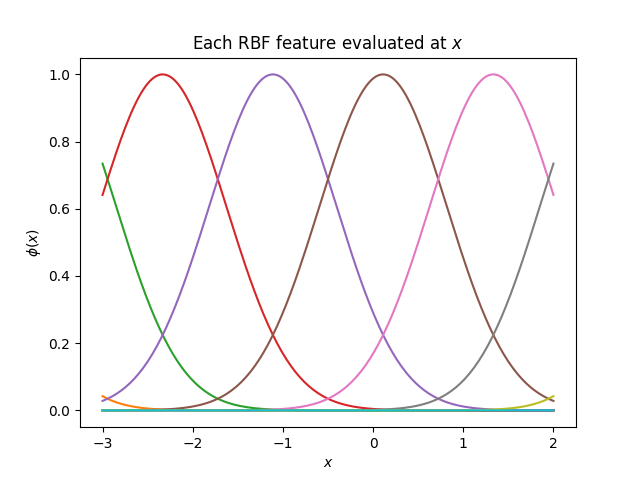

In [3]:
rbf, _ = create_rbf_feature_fun(10)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, rbf(x_plot))
ax.set_title("Each RBF feature evaluated at $x$")
ax.set_xlabel("$x$")
ax.set_ylabel("$\phi(x)$")
None

# Gaussian Kernel function $k(x, x_i)$ against data

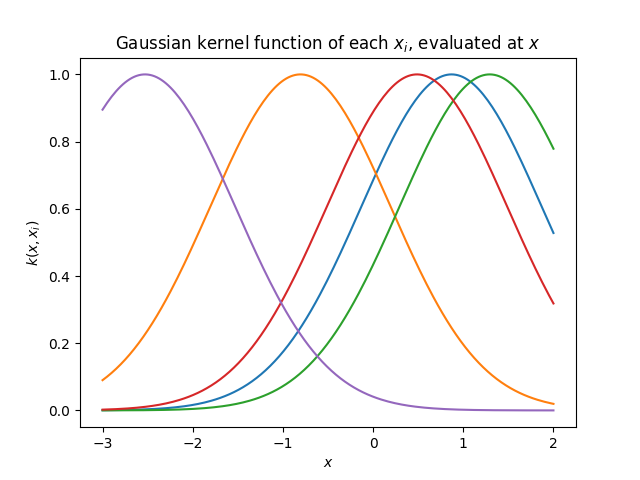

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, gaussian_kernel_function(x_plot, x_data))
ax.set_title("Gaussian kernel function of each $x_i$, evaluated at $x$")
ax.set_xlabel("$x$")
ax.set_ylabel("$k(x, x_i)$")
None

# RBF dot-product Kernel function $k_\phi(x, x_i)$ against data

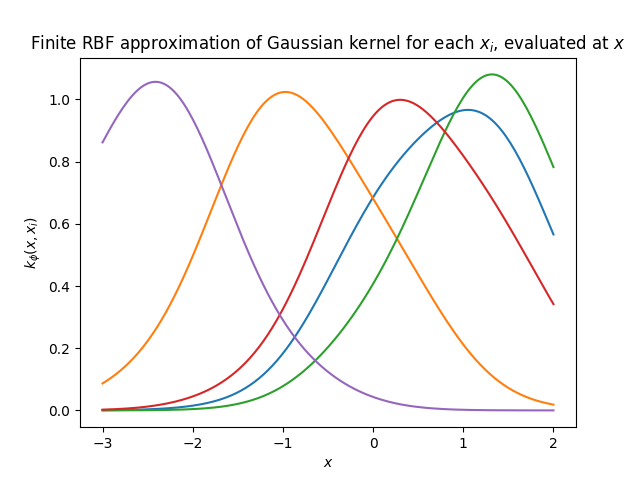

In [5]:
rbf, weighting = create_rbf_feature_fun(10)
rbf_kernel = create_feature_kernel_function(rbf, weighting)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, rbf_kernel(x_plot, x_data))
ax.set_title("Finite RBF approximation of Gaussian kernel for each $x_i$, evaluated at $x$")
ax.set_xlabel("$x$")
ax.set_ylabel("$k_{\phi}(x, x_i)$")
None

# Comparison of Gaussian kernel vs RBF kernel at different feature dimensionalities

interactive(children=(IntSlider(value=10, description='N', max=50, min=1), Output()), _dom_classes=('widget-in…

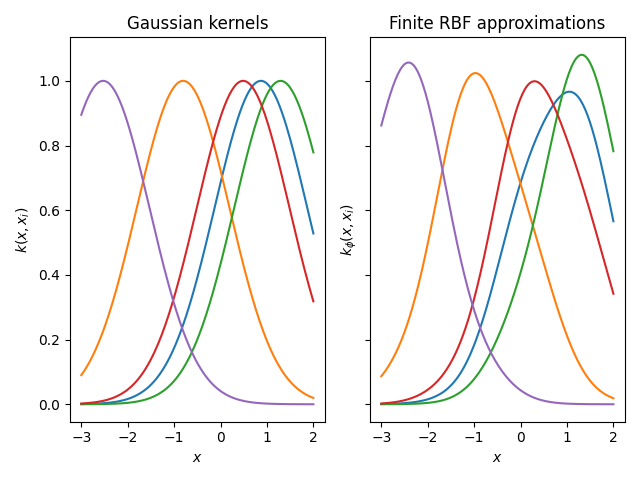

In [6]:
fig = plt.figure()
ax1, ax2 = fig.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
gaussian_lines = ax1.plot(x_plot, gaussian_kernel_function(x_plot, x_data))
rbf_lines = ax2.plot(x_plot, rbf_kernel(x_plot, x_data))

ax1.set_title("Gaussian kernels")
ax1.set_xlabel("$x$")
ax1.set_ylabel("$k(x, x_i)$")

ax2.set_title("Finite RBF approximations")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$k_{\phi}(x, x_i)$")

fig.tight_layout()

def update(N):
    # create rbf features with N centers
    rbf_kernel_N, weighting_N = create_rbf_feature_fun(int(N))
    # and kernel of it
    rbf_kernel_N = create_feature_kernel_function(rbf_kernel_N, weighting_N)
    data_kernel = rbf_kernel_N(x_plot, x_data)
    for i, line in enumerate(rbf_lines):
        line.set_ydata(data_kernel[:, i])
    fig.canvas.draw_idle()
    
_ = interact(update, N = ipywidgets.IntSlider(min=1, max=50, step=1, value=10))


# Kernel Trick

Let's compare runtime and numerical accuracy of both matrix inversions as we increase the feature dimensionality.

We'll first create a few more datapoints and use 15 RBFs.

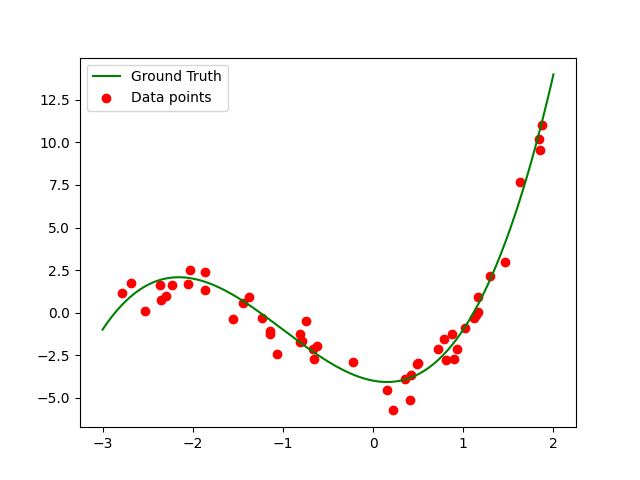

In [7]:
x_min, x_max = -3, 2
num_data = 50
data_noise = 1.0
num_plot = 200

def fun(x):
    return x**3 + 3 * x**2 - x - 4

gen = np.random.default_rng(seed=42)
x_data = gen.uniform(size=(num_data,), low=x_min, high=x_max)
y_data = fun(x_data) + data_noise * gen.standard_normal(x_data.shape) 

x_plot = np.linspace(x_min, x_max, num=num_plot)
y_plot = fun(x_plot)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, y_plot, color="green", label="Ground Truth")
ax.scatter(x_data, y_data, color="red", label="Data points")
ax.legend(loc="upper left")
None

As a reminder:

Ridge regression approach: $w = (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top y, \qquad f(x) = \phi(x)^\top w$

Kernelized approach: $w = \Phi^\top (\Phi \Phi^\top + \lambda I)^{-1} y = \Phi^\top \alpha, \qquad f(x) = \phi(x)^\top \Phi^\top \alpha = k(x)^\top \alpha$

In [8]:
def ridge(rbf, Phi, y_data, reg_lambda):
    # Phi.shape [N, d]
    # w = A^{-1} b -> A w = b
    A = Phi.mT @ Phi + reg_lambda * np.eye(N=Phi.shape[1], dtype=Phi.dtype)
    b = Phi.mT @ y_data
    w = np.linalg.solve(A, b) # solve d x d system
    def f(x_plot):
        assert x_plot.ndim == 1
        # rbf shape [plot, d], w shape [d]
        return (rbf(x_plot) * w[None, :]).sum(axis=-1)
    return f

def kernelized(rbf, Phi, y_data, reg_lambda):
    # Phi.shape [N, d]
    # alpha = A^{-1} b -> A w = b
    A = Phi @ Phi.mT + reg_lambda * np.eye(N=Phi.shape[0], dtype=Phi.dtype)
    b = y_data
    alpha = np.linalg.solve(A, b) # solve N x N system
    def f(x_plot):
        assert x_plot.ndim == 1
        # rbf shape [plot, d], Phi shape [N, d]
        k = (rbf(x_plot)[:, None, :] * Phi[None, :, :]).sum(axis=-1)
        # k shape [plot, N], alpha shape [N]
        return (k * alpha[None, :]).sum(axis=-1)
    return f

Both methods lead to identical $f(x)$

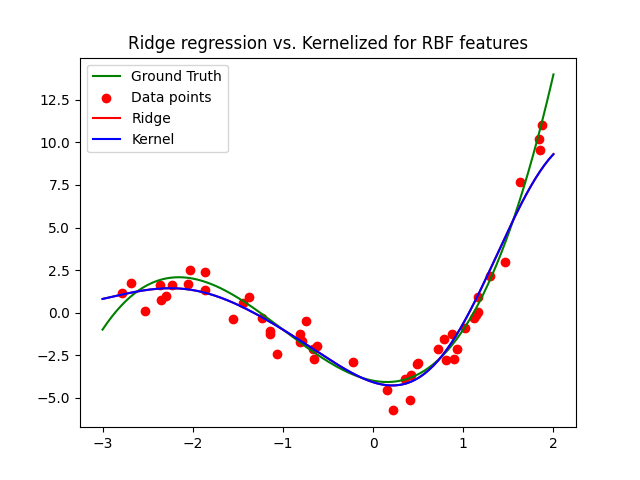

In [9]:
reg_lambda = 0.5

num_rbf = 15

rbf, _ = create_rbf_feature_fun(num_rbf)
Phi = rbf(x_data)

f_r = ridge(rbf, Phi, y_data, reg_lambda)
f_k = kernelized(rbf, Phi, y_data, reg_lambda)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, y_plot, color="green", label="Ground Truth")
ax.scatter(x_data, y_data, color="red", label="Data points")
ax.plot(x_plot, f_r(x_plot), color="red", label="Ridge")
ax.plot(x_plot, f_k(x_plot), color="blue", label="Kernel")
ax.legend(loc="upper left")
ax.set_title("Ridge regression vs. Kernelized for RBF features")
None

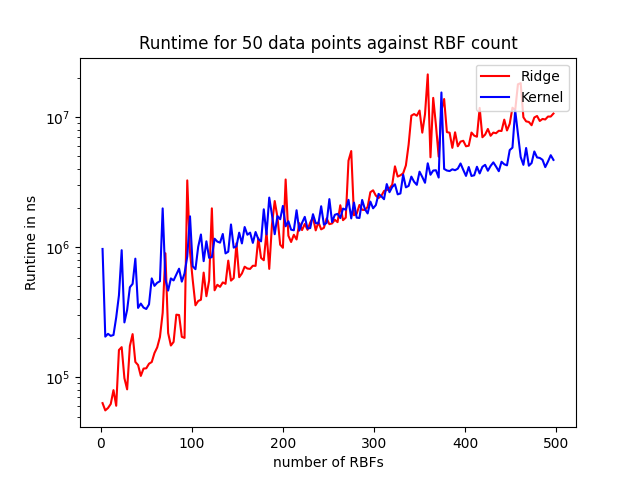

In [10]:
import time

ridge_times = []
kernel_times = []
rbf_dims = list(range(2, 500, 3))

for rbf_dim in rbf_dims:
    rbf, _ = create_rbf_feature_fun(rbf_dim)
    Phi = rbf(x_data)
    
    ridge_start = time.perf_counter_ns()
    f_r = ridge(rbf, Phi, y_data, reg_lambda)
    f_r = ridge(rbf, Phi, y_data, reg_lambda)
    f_r = ridge(rbf, Phi, y_data, reg_lambda)
    # eval has different cost too!
    f_r(x_data)
    f_r(x_data)
    f_r(x_data)
    ridge_time = time.perf_counter_ns() - ridge_start

    kernel_start = time.perf_counter_ns()
    f_k = kernelized(rbf, Phi, y_data, reg_lambda)
    f_k = kernelized(rbf, Phi, y_data, reg_lambda)
    f_k = kernelized(rbf, Phi, y_data, reg_lambda)
    # eval has different cost too!
    f_k(x_data)
    f_k(x_data)
    f_k(x_data)
    kernel_time = time.perf_counter_ns() - kernel_start

    ridge_times.append(ridge_time / 3)
    kernel_times.append(kernel_time / 3)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(rbf_dims, ridge_times, color="red", label="Ridge")
ax.plot(rbf_dims, kernel_times, color="blue", label="Kernel")
ax.legend(loc="upper right")
ax.set_yscale('log')
ax.set_ylabel("Runtime in ns")
ax.set_xlabel("number of RBFs")
ax.set_title(f"Runtime for {num_data} data points against RBF count")
None

# Comparing the numerical stability
Let's set the regularization $\lambda$ to zero and see what happens, depending on $N, d$.

More data, fewer features -> Ridge more stable

Less data, more features -> Kernel more stable

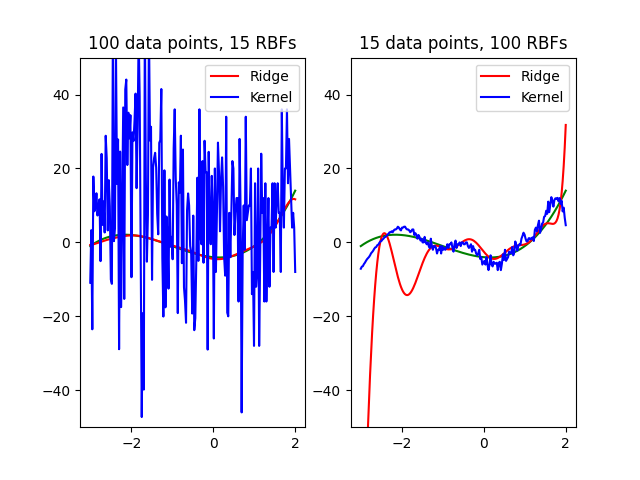

In [11]:
reg_lambda = 1e-7

fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
for n_data, n_rbf, ax in [(100, 15, ax1), (15, 100, ax2)]:
    gen = np.random.default_rng(seed=42)
    x_data = gen.uniform(size=(n_data,), low=x_min, high=x_max).astype(np.float32)
    y_data = fun(x_data) + data_noise * gen.standard_normal(x_data.shape, dtype=np.float32) 

    rbf, _ = create_rbf_feature_fun(n_rbf, dtype=np.float32)
    Phi = rbf(x_data)

    f_r = ridge(rbf, Phi, y_data, reg_lambda)
    f_k = kernelized(rbf, Phi, y_data, reg_lambda)

    ax.plot(x_plot, y_plot, color="green")
    ax.plot(x_plot, f_r(x_plot.astype(np.float32)), color="red", label="Ridge")
    ax.plot(x_plot, f_k(x_plot.astype(np.float32)), color="blue", label="Kernel")
    ax.set_ylim([-50, 50])
    ax.legend(loc="upper right")
    ax.title.set_text(f"{n_data} data points, {n_rbf} RBFs")